# Семинар 2: диффузионные модели

## Вступление
В этом семинаре мы на простом примере попробуем рассмотреть и реализовать принцип работы дифузных моделей поэтапно.

Основной источник для семинара — это великолепный [курс от HuggingFace](https://github.com/huggingface/diffusion-models-class), в котором есть несколько тем по диффузионным моделям.

Другие полезные ссылки:
[Супер теория и use cases](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)

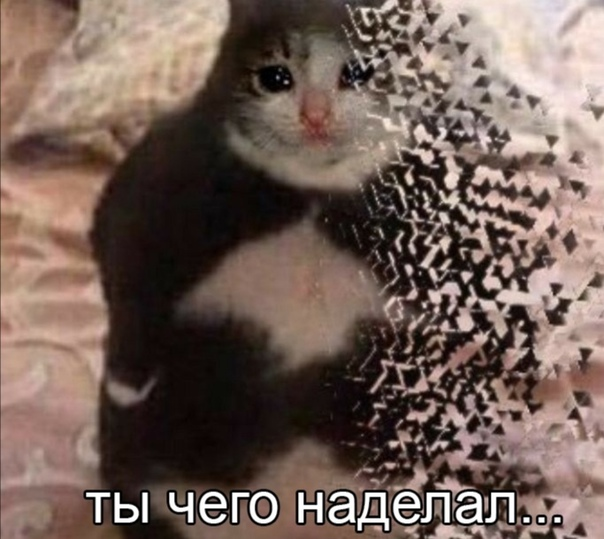


### План семинара:
1. Зашумляем данные
2. Обучаем простейшую диффузионную модель на MNIST
3. Генерируем новые изображения
4. Сравниваем простейшую диффузионную модель с Denoising Diffusion Probabilistic Models (DDPM)
5. Отступление: несколько моментов по статье
6. Реализуем class-conditioned диффузию

In [ ]:
!pip install diffusers -q

In [ ]:
import torch
import torchvision
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Зашумляем данные

Будем использовать данные MNIST. Если ваши глаза больше не могут смотреть на цифры, то можете использовать FashionMNIST, не меняя код.

In [ ]:
dataset = torchvision.datasets.MNIST(
    root="mnist/",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

100%|██████████| 9912422/9912422 [00:00<00:00, 90290316.67it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 16887730.91it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33988231.69it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3976315.75it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([4, 1, 4, 0, 4, 8, 1, 9])


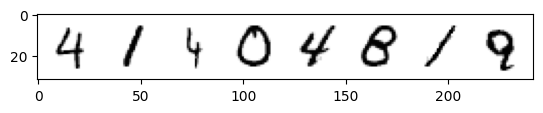

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys");

Представим, что мы хотим с какой-то долей зашумлять наши данные. В идеале — контролировать этот процесс. Как бы мы это делали?

Введем переменную `amount`, которая будет отвечать за количество зашумления и реализуем функцию `corrupt`, которая будет "смешивать" вход `x` со случайным шумом:


In [ ]:
def corrupt(x: torch.Tensor, amount: torch.Tensor) -> torch.Tensor:
    """
    Corrupt the input `x` by mixing it with noise according to `amount`
    :param amount: torch.Tenosr of shape [x.shape[1], x.shape[2], x.shape[3]]
    """
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

Легко заметить, что при `amount=0` никакого зашумления не будет, а при `amount=1` мы полностью зашумим изначальную картинку. Смешивая входные данные с шумом с такими весами, мы сохраняем их в исходном диапазоне – от 0 до 1.

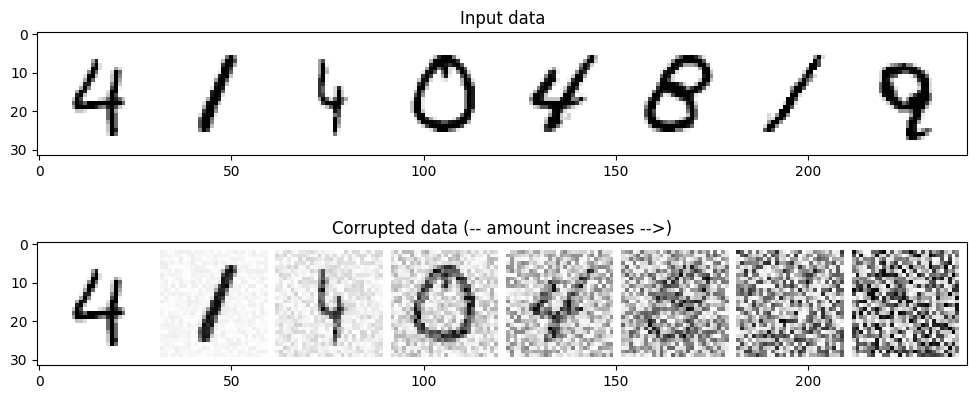

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys");

## 2. Обучаем простейшую диффузионную модель на MNIST
### Модель
Будем использовать (упрощенную) архитектуру UNet, известную нам с прошлого семестра:

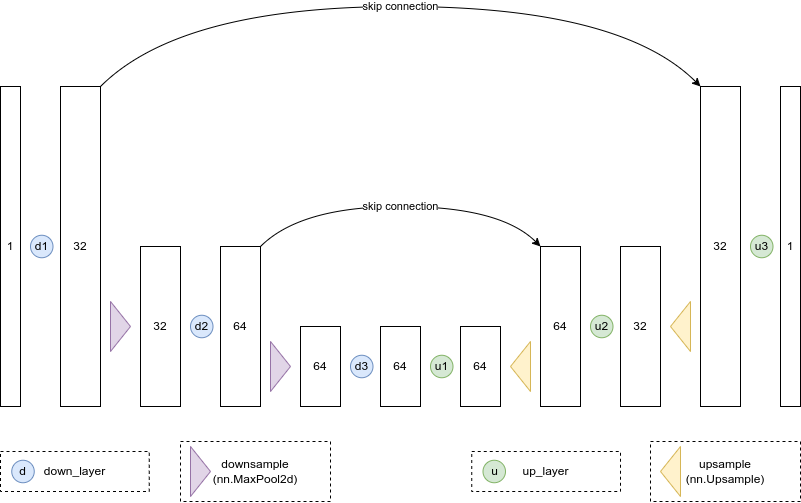

In [ ]:
class BasicUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU()  # activation function
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Through the layer and the activation function
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))  # Through the layer and the activation function

        return x

Проверим размеры выходов сети и посмотрм на количество её параметров:

In [ ]:
net = BasicUNet()
x = torch.rand(8, 1, 28, 28)
assert net(x).shape == x.shape

print(f"Количество параметров в сети: {sum([p.numel() for p in net.parameters()])}")

Количество параметров в сети: 309057


### Обучение

Как будем обучать нашу модель? Потребуем, чтобы нейронная сеть восстаналивала исходную картинку после зашумления. Сравним полученный результат с исходной картинкой с помощью MSE по пикселям.

Finished epoch 0. Average loss for this epoch: 0.02
Finished epoch 1. Average loss for this epoch: 0.02
Finished epoch 2. Average loss for this epoch: 0.02


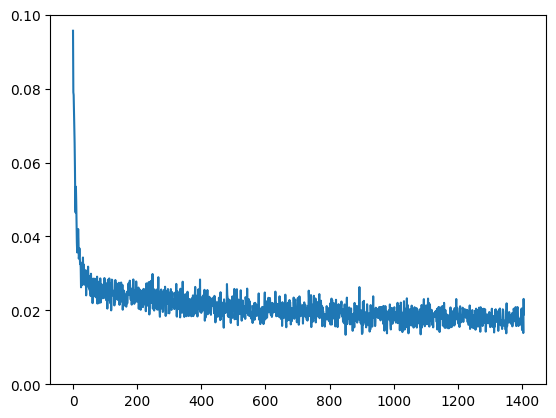

In [ ]:
n_epochs = 3
batch_size = 128

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

net = BasicUNet()
net.to(device)

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for epoch in range(n_epochs):
    for x, y in train_dataloader:
        # Get some data and prepare the corrupted version
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x)

        loss = loss_fn(pred, x)
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:.2f}")

plt.plot(losses)
plt.ylim(0, 0.1);

Давайте посмотрим на то, как модель справляется с шумом:

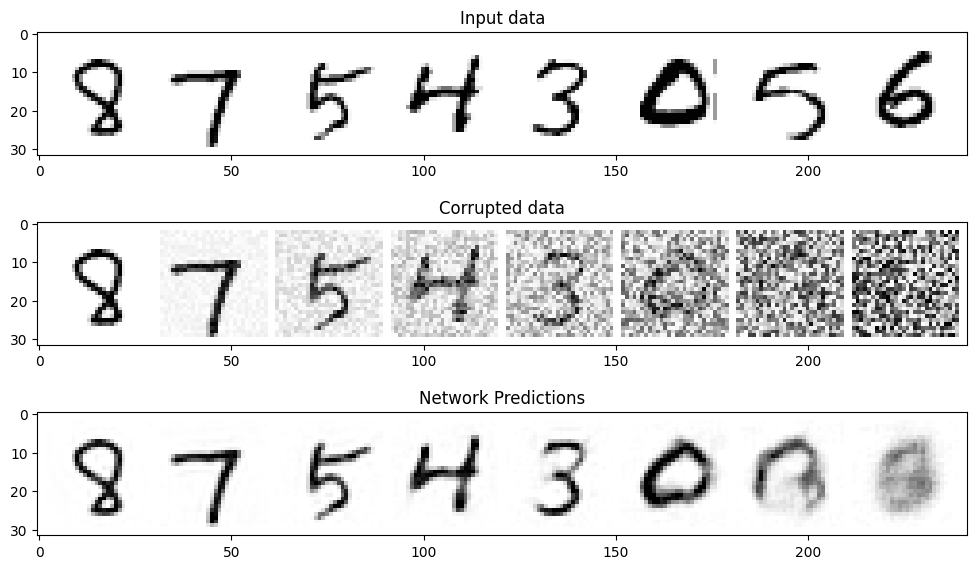

In [ ]:
x, y = next(iter(train_dataloader))
x = x[:8]

# Corrupt with a range of amounts (left to right -> more corruption)
amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Corrupted data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys");

Наблюдения:
1. Достаточно легко и быстро улавливает основные закономерности и до какого-то момента неплохо денойзит
2. При большой зашумленности получается что-то непонятное

## 3. Генерируем новые изображения

При сильной зашумленности предсказания модели получились не очень. Что делать в таком случае? Мы можем попробовать начать со случайного шума. Затем возьмём прогнозы модели и немного продвинемся к этому прогнозу, скажем, на `20%`. У нас получится очень зашумленное изображение, в котором, возможно, есть намек на структуру. Снова передадим это изображение в модель, чтобы получить новый прогноз. Мы надеемся, что этот новый прогноз будет немного лучше первого, потому что изображение зашумлено слабее. Делаем еще один небольшой шаг с этим новым, лучшим прогнозом. Повторим процедуру несколько раз, и (если все пойдет хорошо) мы получим изображение! Ниже запустим этот процесс из 5 шагов.

Обратите внимание: модель предсказывает изображение с шумоподавлением даже на шаге 1. Но далее мы используем взвешенную сумму исходной зашумленной картинки и предсказания модели. И так на каждом шаге, пока мы не получим окончательные результаты.

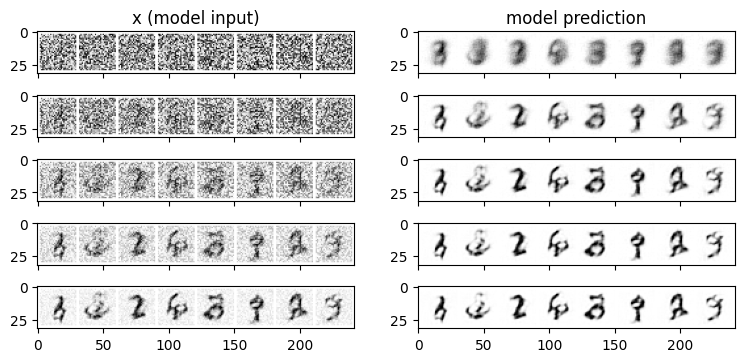

In [ ]:
n_steps = 5
x = torch.rand(8, 1, 28, 28).to(device)
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():
        pred = net(x)  # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    x = x * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
    step_history.append(x.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(
        torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys"
    )
    axs[i, 1].imshow(
        torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys"
    )

Теперь давайте увеличим количество шагов до 40!
И посмотрим только на генерации:

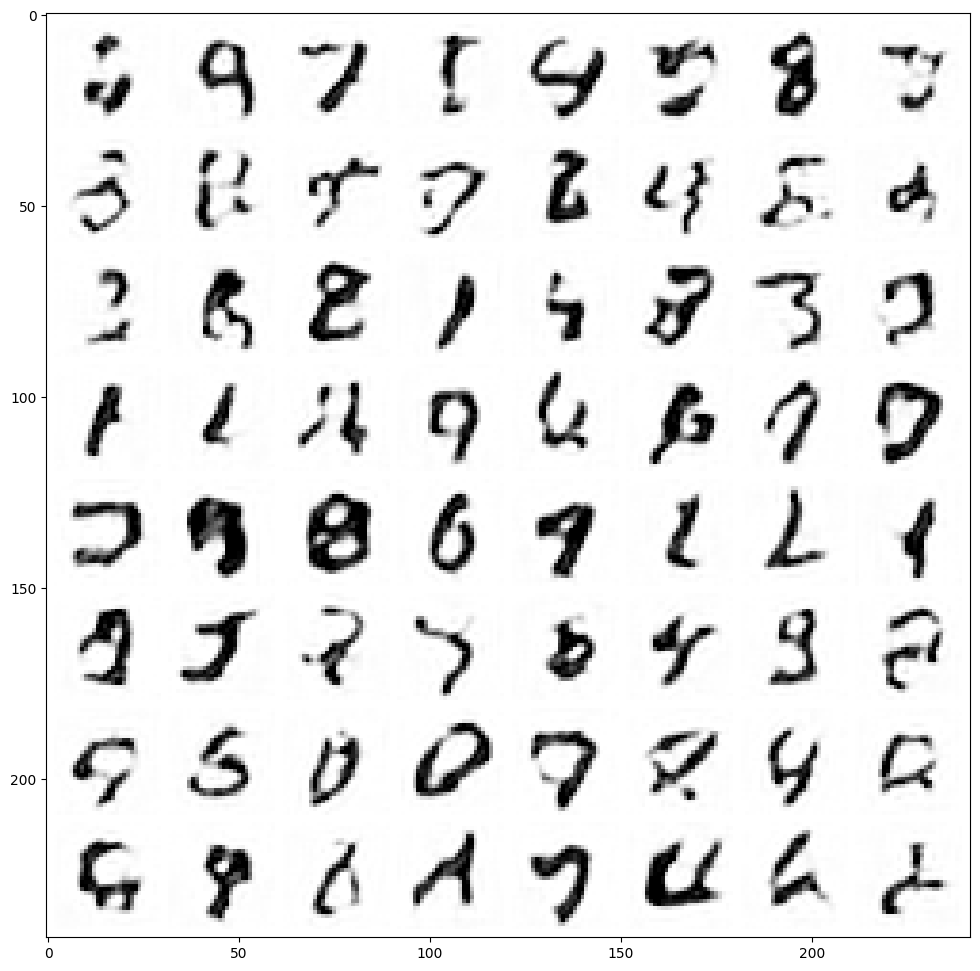

In [ ]:
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = net(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys"
);

Скажем так. Не прекрасно, но и не ужасно. Особенно если помнить, что мы взяли очень легкую модель + всего пару эпох обучения, которые завершились меньше, чем за минуту. Увеличив мощности, можно получить лучшие результаты.

## 4. Сравниваем простейшую диффузионную модель с Denoising Diffusion Probabilistic Models (DDPM)

Сравним нашу игрушечную имплементацию с статейной Denoising Diffusion Probabilistic Models (DDPM) ([Introduction to Diffusers](https://github.com/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb)).

* В статье используется `UNet2DModel`. Она больше и хитрее, чем наша `BasicUNet`
* По-другому сделан процесс зашумления (corruption process)
* Другая цель обучения: модель прогнозирует сам шум, а не изображение до зашумления.
* В модели есть дополнительный параметр `t` (время), который передается на вход метода `forward`.
* Другие стратегии генерации новых изображений. Они должны работать лучше нашей упрощенной версии.

После выхода статьи о DDPM было предложено несколько улучшений, но мы надеемся, что и этот пример будет достаточно показательным. Советуем также [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364). В ней подробно рассматриваются идеи из оригинальной статьи и даются новые рекомендации о том, как добиться наилучшей производительности.

In [ ]:
net = UNet2DModel(
    sample_size=28,  # target image resolution
    in_channels=1,
    out_channels=1,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # regular ResNet downsampling block
        "AttnDownBlock2D",  # ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # regular ResNet upsampling block
    ),
).to(device)

sum([p.numel() for p in net.parameters()])  # 1.7M vs ~309k parameters of the BasicUNet

1707009

Попробуем воспроизвести обучение простой модели из начала семинара, используя модель из статьи вместо нашей исходной. На каждом шаге в модель нужно передавать `x`, так и временной шаг. Здесь мы всегда передаём `t = 0`, чтобы показать, что она работает и без временного шага. Вы также можете попробовать ввести `(amount * 1000)`.

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average loss for this epoch: 0.019615


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average loss for this epoch: 0.012927


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average loss for this epoch: 0.011745


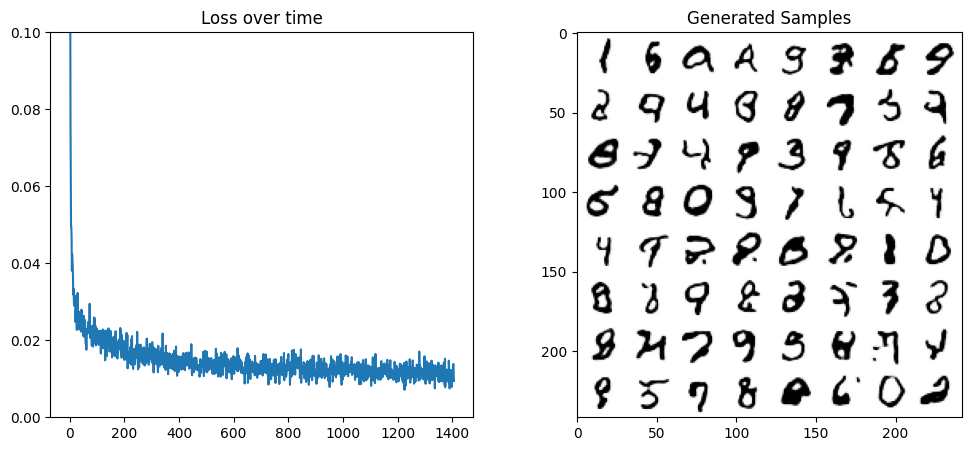

In [ ]:
n_epochs = 3
batch_size = 128

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        # Get some data and prepare the corrupted version
        x = x.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x, 0).sample  # <<< Using timestep 0 always, adding .sample

        loss = loss_fn(pred, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = net(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1), cmap="Greys"
)
axs[1].set_title("Generated Samples");

Судя по лоссу, архитектура из статьи гораздо лучше справляется с расшумлением изображений!

## 5. Отступление: несколько моментов по статье

### Процесс зашумления (The Corruption Process)

В статье DDPM описывается процесс зашумления, который добавляет небольшое количество шума для каждого «временного шага». Имея $x_{t-1}$ для некоторого временного шага $t$, мы можем получить следующую (чуть более шумную) версию $x_t$ как:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x} _{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t -1})$<br><br>


Иными словами, мы берем $x_{t-1}$, масштабируем его на $\sqrt{1 - \beta_t}$ и добавляем шум, масштабированный на $\beta_t$. Эта $\beta_t$ определяется для каждого $t$ в соответствии с некоторым расписанием (scheduler). Она определяет, сколько шума добавляется за каждый временной шаг.

Нам не нужно выполнять эту операцию 500 раз, чтобы получить $x_{500}$, потому что у нас есть другая формула для получения $x_t$ для любого заданного $t$ и $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \sqrt{(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$, где $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ и $\alpha_i = 1-\beta_i$<br><br>

Выглядит страшно! К счастью, планировщик обрабатывает все это за нас:

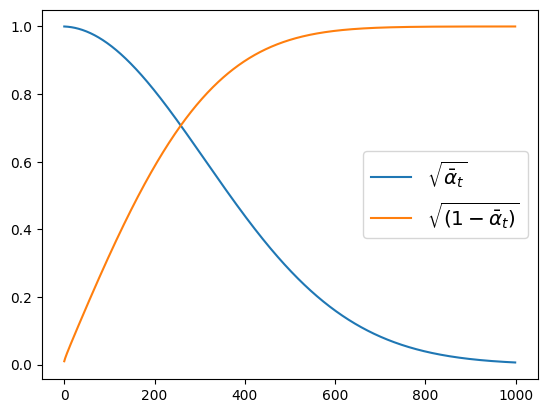

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)  # Задаем наш scheduler
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large");

Сначала зашумленный $x$ в основном равен $x \sqrt{\overline \alpha_t} \approx x$. Но со временем вклад $x$ падает, а шумовая составляющая увеличивается. В отличие от способа зашумления из начала семинара (функция `corrupt`), тут картинка зашумляется относительно быстро.

Выглядит это вот так:

X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


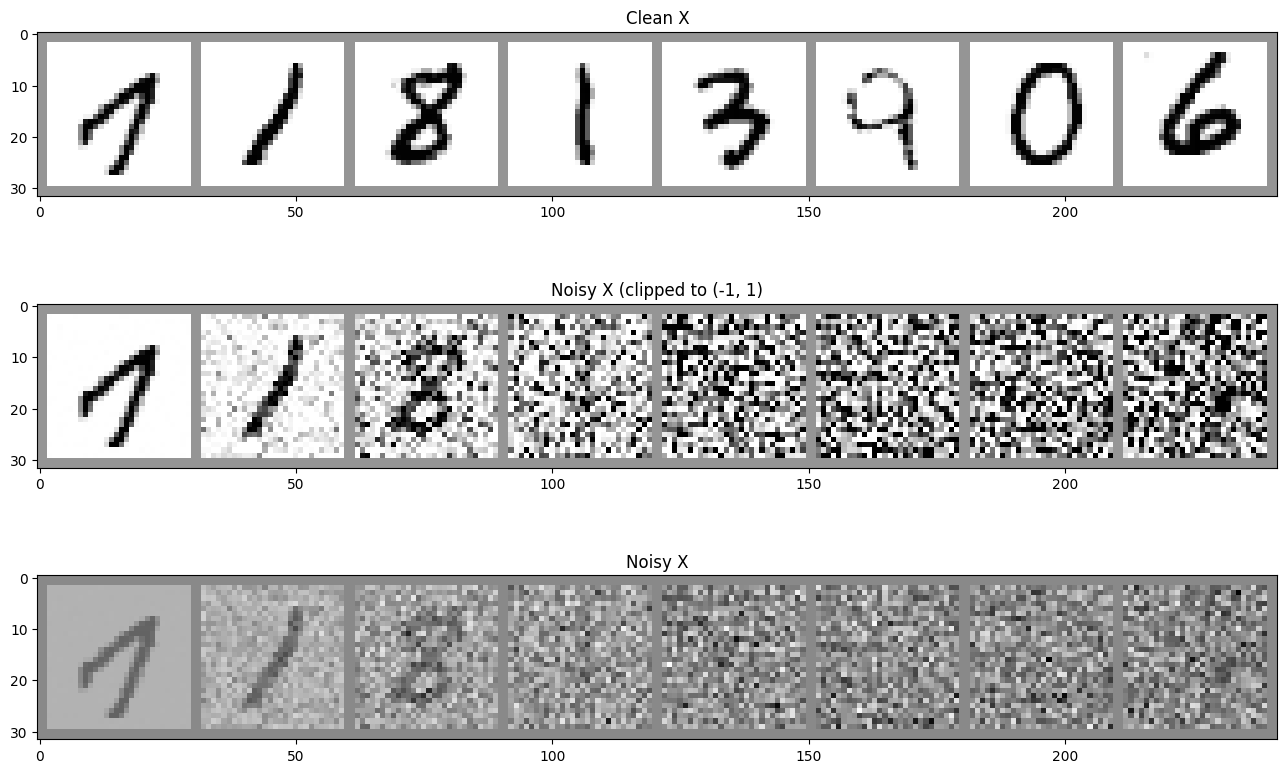

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(16, 10))
xb, yb = next(iter(train_dataloader))
xb = xb.to(device)[:8]
xb = xb * 2.0 - 1.0  # Map to (-1, 1)
print("X shape", xb.shape)

# Show clean inputs
axs[0].imshow(torchvision.utils.make_grid(xb[:8])[0].detach().cpu(), cmap="Greys")
axs[0].set_title("Clean X")

# Add noise with scheduler
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)  # << NB: randn not rand
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)

# Show noisy version (with and without clipping)
axs[1].imshow(
    torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu().clip(-1, 1),
    cmap="Greys",
)
axs[1].set_title("Noisy X (clipped to (-1, 1)")
axs[2].imshow(torchvision.utils.make_grid(noisy_xb[:8])[0].detach().cpu(), cmap="Greys")
axs[2].set_title("Noisy X");

Кроме того, DDPM добавляет шум, взятый из распределения Гаусса (среднее значение 0, стандартное отклонение 1 из `torch.randn`). Ранее мы использовали равномерный шум между 0 и 1 (из `torch.rand`). В общем случае имеет смысл нормализовать и обучающие данные.

### Обучение

В нашем игрушечном примере модель пыталась предсказать изображение без шума. В DDPM и во многих других реализациях диффузионной модели нейросеть предсказывает шум, используемый в процессе искажения. В коде это выглядит примерно так:

```python
noise = torch.randn_like(xb) # << NB: randn not rand
noisy_x = noise_scheduler.add_noise(x, noise, timesteps)
model_prediction = model(noisy_x, timesteps).sample
loss = mse_loss(model_prediction, noise) # noise as the target
```

Вы можете подумать, что прогнозирование шума (из которого мы можем вывести, как выглядит изображение с шумоподавлением) эквивалентно простому прогнозированию изображения с шумоподавлением напрямую. **Так зачем отдавать предпочтение одному перед другим — для математического удобства?**

Мы вычисляем потери на разных (случайно выбранных) временных шагах во время обучения. Эти разные цели приведут к различному «неявному взвешиванию» потерь, когда прогнозирование шума придает больший вес более низким уровням шума. Вы можете выбрать более сложные цели, чтобы изменить это «неявное взвешивание потерь». Или, возможно, вы выберете график шума, который приведет к большему количеству примеров с более высоким уровнем шума.

На данный момент прогнозирование шума является предпочтительным подходом. Но со временем мы, вероятно, увидим другие цели, поддерживаемые в библиотеке и используемые в различных ситуациях.

### Временной шаг (timestamp conditioning)

`UNet2DModel` принимает не только $x$, так и временной шаг $t$ (эмбеддинг). Таким образом мы передаем модели **информацию об уровне шума**, который необходимо спрогнозировать. На ранних этапах этого шума в изображении меньше, на поздних – больше. Это позволяет нейросети лучше выполнить свою задачу.

Несмотря на то, что можно обучить модель и без информации о времени, в некоторых случаях это помогает повысить производительность. Большинство реализаций используют время, по крайней мере, сегодня.

## 6. Реализуем class-conditioned диффузию

In [ ]:
class ClassConditionedUnet(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=4):
        super().__init__()

        # The embedding layer will map the class label to a vector of size class_emb_size
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # Self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
        self.model = UNet2DModel(
            sample_size=28,  # the target image resolution
            in_channels=1 + class_emb_size,  # Additional input channels for class cond.
            out_channels=1,  # the number of output channels
            layers_per_block=2,  # how many ResNet layers to use per UNet block
            block_out_channels=(32, 64, 64),
            down_block_types=(
                "DownBlock2D",  # a regular ResNet downsampling block
                "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ),
            up_block_types=(
                "AttnUpBlock2D",
                "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",  # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, class_labels):
        # Shape of x:
        bs, ch, w, h = x.shape

        # class conditioning in right shape to add as additional input channels
        class_cond = self.class_emb(class_labels)  # Map to embedding dinemsion
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(
            bs, class_cond.shape[1], w, h
        )
        # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1)  # (bs, 5, 28, 28)

        # Feed this to the unet alongside the timestep and return the prediction
        return self.model(net_input, t).sample  # (bs, 1, 28, 28)

In [ ]:
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 0. Average of the last 100 loss values: 0.054354


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 1. Average of the last 100 loss values: 0.046980


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 2. Average of the last 100 loss values: 0.043353


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 3. Average of the last 100 loss values: 0.043198


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 4. Average of the last 100 loss values: 0.042211


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 5. Average of the last 100 loss values: 0.040651


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 6. Average of the last 100 loss values: 0.039507


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 7. Average of the last 100 loss values: 0.039324


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 8. Average of the last 100 loss values: 0.039211


  0%|          | 0/469 [00:00<?, ?it/s]

Finished epoch 9. Average of the last 100 loss values: 0.038996


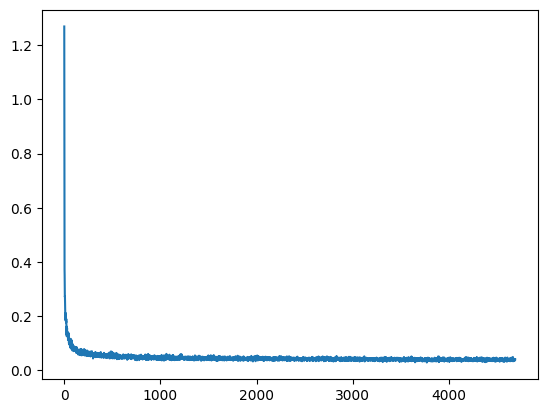

In [ ]:
n_epochs = 10

train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

net = ClassConditionedUnet().to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-3)

losses = []

for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        # Get some data and prepare the corrupted version
        x = x.to(device) * 2 - 1
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        pred = net(noisy_x, timesteps, y)  # Note that we pass in the labels y

        loss = loss_fn(pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-100:]) / 100
    print(
        f"Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}"
    )

plt.plot(losses);

0it [00:00, ?it/s]

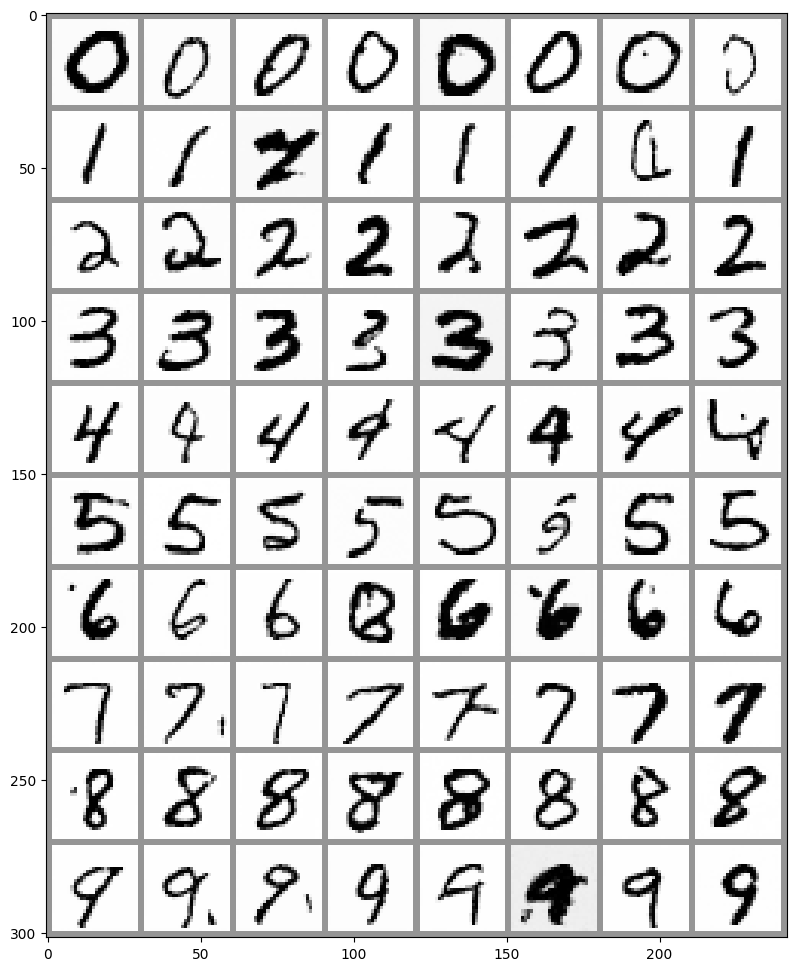

In [ ]:
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i] * 8 for i in range(10)]).flatten().to(device)

# Sampling loop
for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(
    torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap="Greys"
);

Теперь вся власть в наших руках и мы можем заставить модель генерировать цифру, которую мы хотим!

## 7. Stable Diffusion

Stable Diffusion основана на определенном типе диффузионных моделей **Latent Diffusion**, предложеном в [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).

Latent diffusion позволяет снизить сложность по памяти и вычислениям за счет того, что мы запускаем диффузионные процессы в низкоразмерном латентом пространстве вместо исходного простраства изображений. В этом и заключается главное различие латентных моделей.

Весь пайплайн состоит из трех основных комнонентов:

1. Автокодировщика (VAE).
2. [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. Текстового кодировщика, например [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>
На вход модели подается текстовое описание изображения. Мы используем `random seed` для генерации случайного латентного представления изображения размером
$64 \times 64$, а текст в тензор размером $77 \times 768$ через текстовый кондировщик CLIP'а.

Затем U-Net занимается итеративным денойзингом случайного латентного представления, обуславливаясь на текстовые эмюеддинги.Процесс "расшумления" повторяется 50 раз, постепенно предоставляя все более хорошее и осознанное латентное представление изображения.

Наконец, сжатое представление декадируется с помощью decoder части VAE.

In [ ]:
!pip install accelerate -q

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Загрузим автокодировщик, который будем использовать для декодирования изображений из латентного представления.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Загрузим текстовый токенайзер и кодировщик для обработки описания изображения
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. Загрузим UNet модель для диффузионных процессов.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

In [ ]:
prompt = ["""masterpiece, best quality, ultra-detailed, deep space around an astronaut riding a horse, highly detailed lighting and shadows"""]

height = 512
width = 512

num_inference_steps = 100

guidance_scale = 7.5

generator = torch.manual_seed(32)

batch_size = 1

Отоюразим наше текстовое описание в пространство эмбеддингов с помощью текстового энкодера.

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

Создадим еще один вход для нашей модели. Подробнее о том, что такое  [classifier-free guidance](https://arxiv.org/abs/2207.12598).

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Сэмплируем шум для начала нашего диффузионного процесса.

In [ ]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(device)
latents.shape

<ipython-input-39-1bdaff9b67bf>:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


torch.Size([1, 4, 64, 64])

Используем `scheduler` для создания входа модели, учитывающего `timestep`.



In [ ]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
scheduler.set_timesteps(num_inference_steps)

In [ ]:
latents = latents * scheduler.init_noise_sigma

Запускаем диффузионный процесс в латентном пространстве.

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/100 [00:00<?, ?it/s]

Используем автокодировщик для того, чтобы восстановить изображение из полученного латентного представления после завершения диффузионного процесса.

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

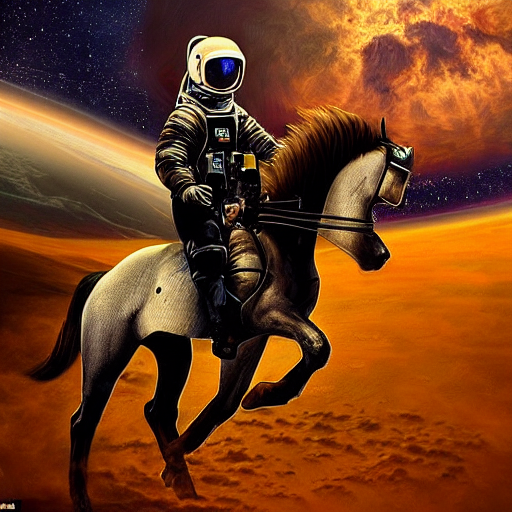

In [ ]:
from PIL import Image

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]